#### caffe load params from mxnet 

##### mxnet load params

Q: 

I am trying to use Batch Normalization in the project I am working on. Since BatchNorm has different use cases for training and validation, I wanted to be sure what is the proper way to use the operator. When I include BatchNorm in my network, I get two argument buffers (gamma and beta) which correspond to the coefficient and bias terms of the BN transformation, as stated in the original paper http://arxiv.org/pdf/1502.03167v1.pdf. And I have two auxiliary buffers for the moving average and moving variance, which are to be used in the validation phase. My question is, what I need to do use these both correctly? For example, the inputs must be transformed with an affine function where the coefficient and bias terms are calculated with learned gamma-beta and moving average-moving variance parameters, in the validation phase. When I execute the 'forward' method of the executor, produced out of this network, there is an argument 'is_train', set to true-false according to the current calling purpose. Does this flag somehow informs the BatchNorm operator of the correct use case? Or do I need to do calculate the transformation parameters by hand, for example?

A:

For training, which means is_train==True, the mean is calculated by using the batch statistics, and so is the var. After this the data is subtracted by the mean and divided by the var. This happens in forward phase. In backward, apart from back propagate the error, the moving_mean and moving_var get updated by using momentum. If your momentum is small, the moving_mean and moving_var can change a little bit fast. For inference, the batch_mean and batch_var are no longer calculated. Instead, it uses moving_mean and moving_var as kind of global statistics.

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Python/2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
import mxnet as mx
import caffe
import numpy as np
import cv2

/Library/Python/2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def postprocess(img, out):   
    h = img.shape[0]
    w = img.shape[1]
    box = out['detection_out'][0,0,:,3:7] * np.array([w, h, w, h])

    cls = out['detection_out'][0,0,:,1]
    conf = out['detection_out'][0,0,:,2]
    return (box.astype(np.int32), conf, cls)

In [4]:
caffe.set_mode_cpu()
ctx = mx.cpu()

In [5]:
sym, arg, aux = mx.model.load_checkpoint('/Users/niekai/PycharmProjects/MobileNet-SSD/deploy_crop_mobilenet025-ssd-224',
                                        epoch=1230)

In [6]:
internals = sym.get_internals()

In [7]:
for i in range(len(internals)):
    print i, internals[i]

0 <Symbol data>
1 <Symbol conv_1_conv2d_weight>
2 <Symbol conv_1_conv2d>
3 <Symbol conv_1_batchnorm_gamma>
4 <Symbol conv_1_batchnorm_beta>
5 <Symbol conv_1_batchnorm_moving_mean>
6 <Symbol conv_1_batchnorm_moving_var>
7 <Symbol conv_1_batchnorm>
8 <Symbol conv_1_relu>
9 <Symbol conv_2_dw_conv2d_weight>
10 <Symbol conv_2_dw_conv2d>
11 <Symbol conv_2_dw_batchnorm_gamma>
12 <Symbol conv_2_dw_batchnorm_beta>
13 <Symbol conv_2_dw_batchnorm_moving_mean>
14 <Symbol conv_2_dw_batchnorm_moving_var>
15 <Symbol conv_2_dw_batchnorm>
16 <Symbol conv_2_dw_relu>
17 <Symbol conv_2_conv2d_weight>
18 <Symbol conv_2_conv2d>
19 <Symbol conv_2_batchnorm_gamma>
20 <Symbol conv_2_batchnorm_beta>
21 <Symbol conv_2_batchnorm_moving_mean>
22 <Symbol conv_2_batchnorm_moving_var>
23 <Symbol conv_2_batchnorm>
24 <Symbol conv_2_relu>
25 <Symbol conv_3_dw_conv2d_weight>
26 <Symbol conv_3_dw_conv2d>
27 <Symbol conv_3_dw_batchnorm_gamma>
28 <Symbol conv_3_dw_batchnorm_beta>
29 <Symbol conv_3_dw_batchnorm_moving_mean>

In [8]:
conv_vis = internals[238]
group = mx.symbol.Group([conv_vis])

In [9]:
mod = mx.mod.Module(symbol=group, context=ctx)
mod.bind(data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params=arg, aux_params=aux)

/Library/Python/2.7/site-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/Library/Python/2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [10]:
net = caffe.Net('/Users/niekai/PycharmProjects/MobileNet-SSD/MobileNetSSD_deploy_copy.prototxt', 
                caffe.TEST)

In [11]:
for i in range(1, 13):
    net.params['conv' + str(i)][0].data[...] = arg['conv_' + str(i) + '_conv2d_weight'].asnumpy()
    net.params['conv' + str(i) + '/bn'][0].data[...] = aux['conv_' + str(i) + '_batchnorm_moving_mean'].asnumpy()
    net.params['conv' + str(i) + '/bn'][1].data[...] = aux['conv_' + str(i) + '_batchnorm_moving_var'].asnumpy()
    net.params['conv' + str(i) + '/bn'][2].data[...] = 1
    net.params['conv' + str(i) + '/scale'][0].data[...] = arg['conv_' + str(i) + '_batchnorm_gamma'].asnumpy()
    net.params['conv' + str(i) + '/scale'][1].data[...] = arg['conv_' + str(i) + '_batchnorm_beta'].asnumpy()

    if i > 1:
        net.params['conv' + str(i) + '/dw'][0].data[...] = arg['conv_' + str(i) + '_dw_conv2d_weight'].asnumpy()
        net.params['conv' + str(i) + '/dw' + '/bn'][0].data[...] = aux['conv_' + str(i) + '_dw_batchnorm_moving_mean'].asnumpy()
        net.params['conv' + str(i) + '/dw' + '/bn'][1].data[...] = aux['conv_' + str(i) + '_dw_batchnorm_moving_var'].asnumpy()
        net.params['conv' + str(i) + '/dw' + '/bn'][2].data[...] = 1
        net.params['conv' + str(i) + '/dw' + '/scale'][0].data[...] = arg['conv_' + str(i) + '_dw_batchnorm_gamma'].asnumpy()
        net.params['conv' + str(i) + '/dw' + '/scale'][1].data[...] = arg['conv_' + str(i) + '_dw_batchnorm_beta'].asnumpy()
    if i in [6, 10, 12]:
        #loc_pred
        net.params['conv' + str(i) + '_mbox_loc_3*3'][0].data[...] = arg['conv_' + str(i) + '_relu_dw_3x3_loc_pred_conv_weight'].asnumpy()
        net.params['conv' + str(i) + '_mbox_loc_3*3'][1].data[...] = arg['conv_' + str(i) + '_relu_dw_loc_pred_conv_bias'].asnumpy()
        
        net.params['conv' + str(i) + '_mbox_loc'][0].data[...] = arg['conv_' + str(i) + '_relu_dw_1x1_loc_pred_conv_weight'].asnumpy()
        net.params['conv' + str(i) + '_mbox_loc'][1].data[...] = arg['conv_' + str(i) + '_relu_loc_pred_conv_bias'].asnumpy()
        
        #cls_pred
        net.params['conv' + str(i) + '_mbox_conf_3*3'][0].data[...] = arg['conv_' + str(i) + '_relu_dw_3x3_cls_pred_conv_weight'].asnumpy()
        net.params['conv' + str(i) + '_mbox_conf_3*3'][1].data[...] = arg['conv_' + str(i) + '_relu_dw_cls_pred_conv_bias'].asnumpy()
        
        net.params['conv' + str(i) + '_mbox_conf'][0].data[...] = arg['conv_' + str(i) + '_relu_dw_1x1_cls_pred_conv_weight'].asnumpy()
        net.params['conv' + str(i) + '_mbox_conf'][1].data[...] = arg['conv_' + str(i) + '_relu_cls_pred_conv_bias'].asnumpy()

In [79]:
net.save('/Users/niekai/PycharmProjects/MobileNet-SSD/MobileNetSSD_deploy_copy.caffemodel')

mxnet predict test

```python
out_mxnet = mod.predict(mx.io.NDArrayIter(input_data))
w = img.shape[1]
h = img.shape[0]
box_mxnet = out_mxnet[0,0,1:5].asnumpy() * np.array([w,h,w,h])
box_mxnet = box_mxnet.astype(np.int32)
p1 = (box_mxnet[0], box_mxnet[1])
p2 = (box_mxnet[0] + box_mxnet[2], box_mxnet[1] + box_mxnet[3])
cv2.rectangle(img, p1, p2, (255,0,0))
```

#### load model and predict test

In [15]:
net = caffe.Net('/Users/niekai/PycharmProjects/MobileNet-SSD/MobileNetSSD_deploy_copy.prototxt','/Users/niekai/PycharmProjects/MobileNet-SSD/MobileNetSSD_deploy_copy.caffemodel',caffe.TEST)

In [16]:
img = cv2.imread('previmg.jpg')
img = cv2.resize(img, (224,224))
input_data = np.transpose(img, (2,0,1))
input_data = input_data[np.newaxis, :,:,:]

In [17]:
net.blobs['data'].data[...] = input_data

out_caffe = net.forward()

net.blobs['data'].data[...] = input_data

In [18]:
out_caffe = net.forward()

In [19]:
out_caffe['detection_out'].shape

(1, 1, 2, 7)

In [20]:
out_caffe['detection_out'][0,0,0,:]

array([0.        , 1.        , 0.61071324, 0.45757395, 0.06560783,
       0.6238219 , 0.39187235], dtype=float32)

In [21]:
box,cls,conf = postprocess(img, out_caffe)

In [22]:
box = box[cls > 0.5]
conf = conf[cls > 0.5]
cls = cls[cls > 0.5]

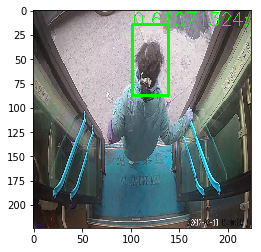

In [23]:
for i in range(len(box)):
   p1 = (box[i][0], box[i][1])
   p2 = (box[i][2], box[i][3])
   cv2.rectangle(img, p1, p2, (0,255,0), 2)
   p3 = (max(p1[0], 15), max(p1[1], 15))
   title = "%s:%.2f" % (str(cls[i]), conf[i])
   cv2.putText(img, title, p3, cv2.FONT_ITALIC, 0.6, (0, 255, 0), 1)
imshow(img)